# Direct Preference Optimization (DPO) for LLM Alignment (From Scratch)
A brief introduction to DPO

* DPO, proposed in the paper Direct Preference Optimization: Your Language Model is Secretly a Reward Model, is an alternative to reinforcement learning from human feedback (RLHF) used in finetuning large language models (LLMs)
* DPO can be used to finetune (or align) the model to generate responses that better align with user expectations and instructions
* In instruction finetuning, we train the LLM to generate correct answers given a prompt
* However, in practice, there are multiple ways to give a correct answer, and correct answers can differ in style; for example, consider a technical and a more user-friendly response when asking an LLM to give recommendations when buying a laptop, as shown in the figure below

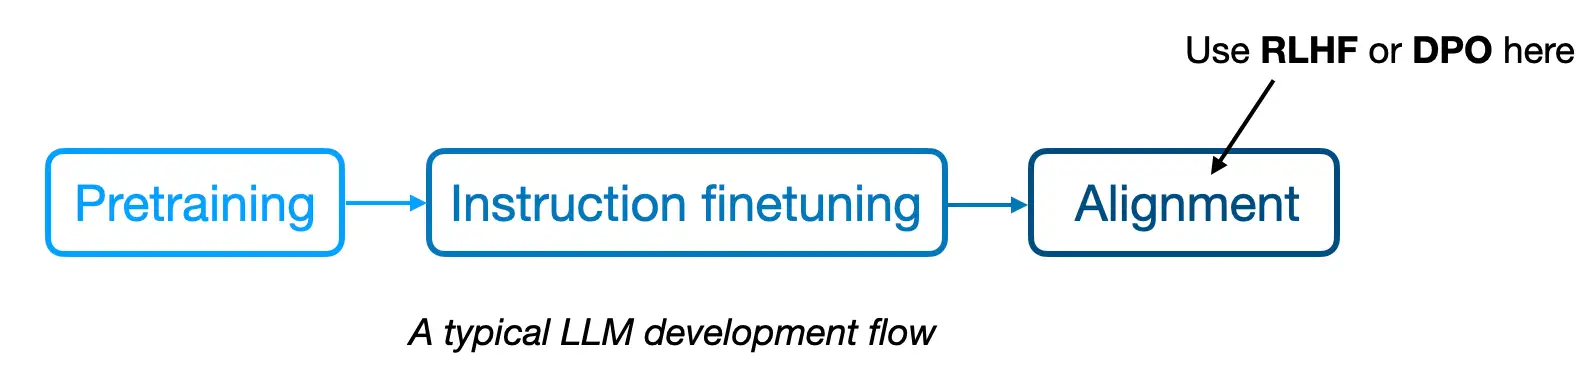

* Proximal policy optimization (PPO) and DPO are methods that can be used to teach the LLM to prefer one answer style over the other, that is, aligning better with user preferences
* The PPO process, which requires training a separate reward model, is outlined below

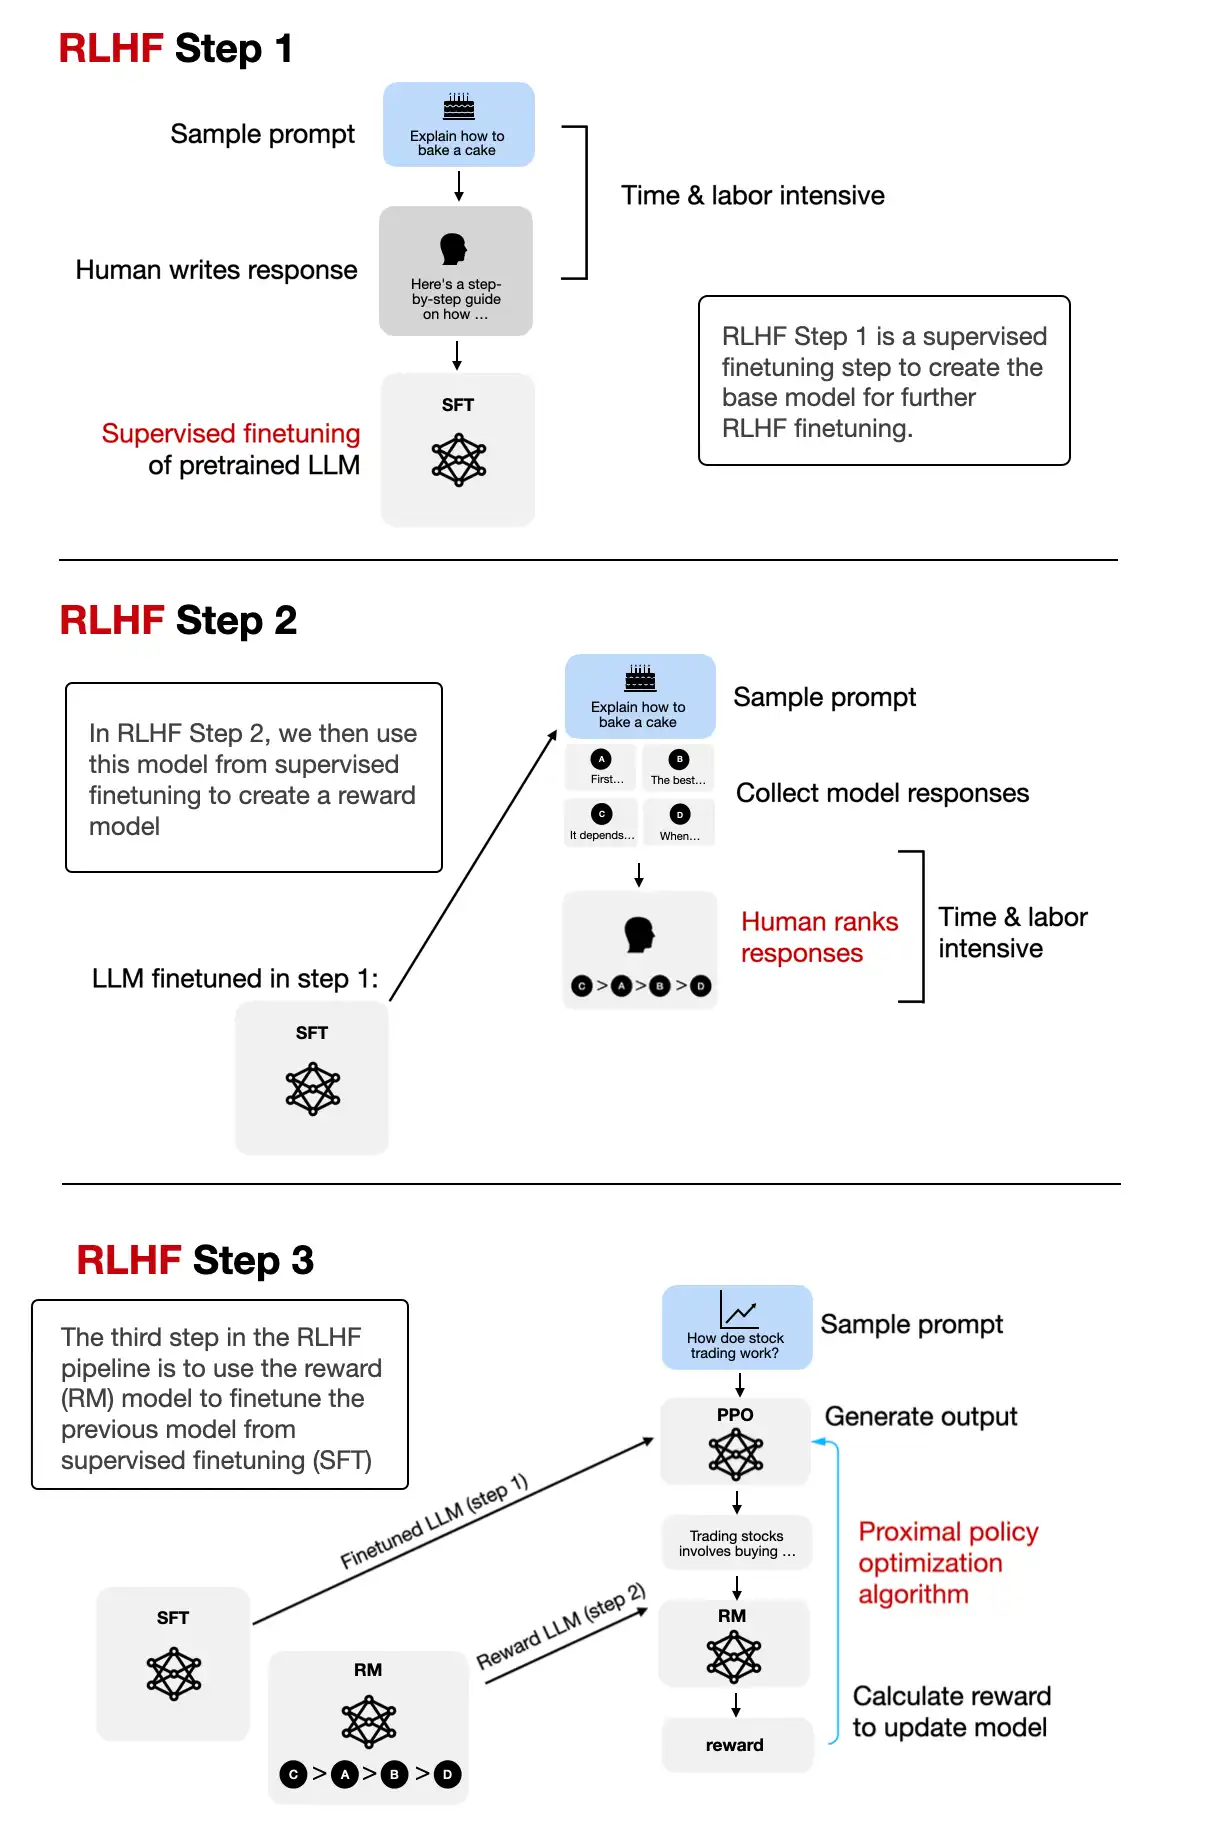

* Compared to PPO, DPO aims to simplify the process by optimizing models directly for user preferences without the need for complex reward modeling and policy optimization
* In other words, DPO focuses on directly optimizing the model's output to align with human preferences or specific objectives
* Shown below is the main idea as an overview of how DPO works

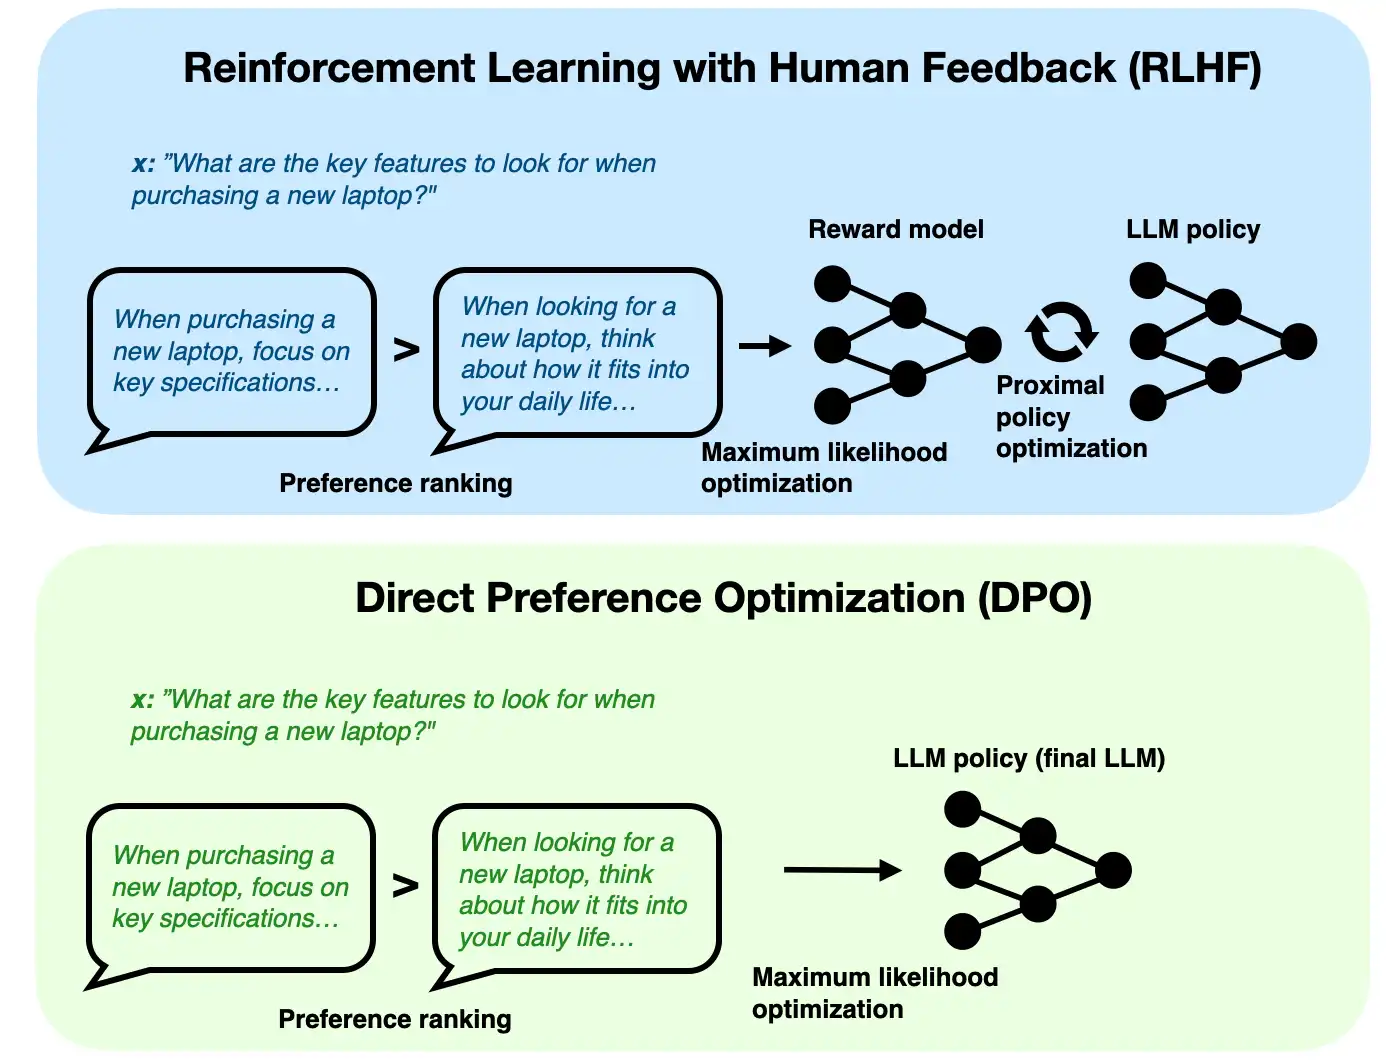

* The concrete equation to implement the DPO loss is shown below; we will revisit the equation when we implement it in Python further down in this code notebook

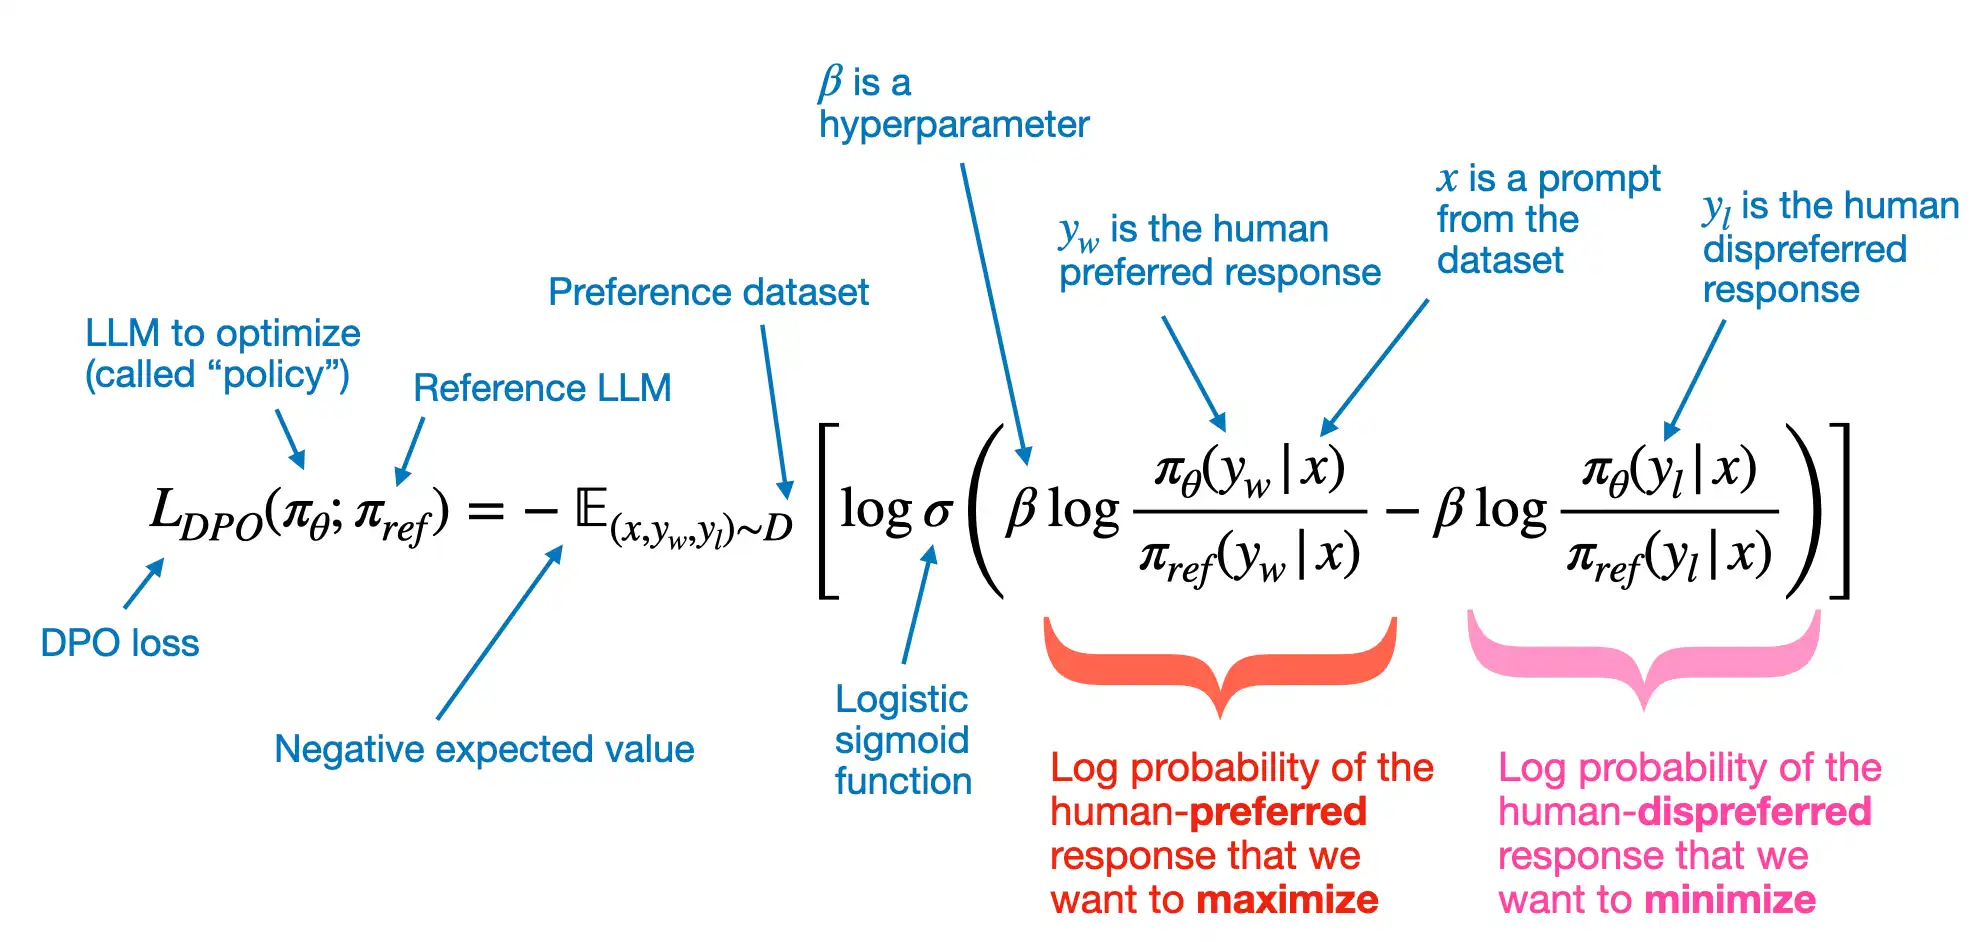

In the equation above,
* "expected value" is statistics jargon and stands for the average or mean value of the random variable (the expression inside the brackets); optimizing aligns the model better with user preferences
* The variable is the so-called policy (a term borrowed from reinforcement learning) and represents the LLM we want to optimize; is a reference LLM, which is typically the original LLM before optimization (at the beginning of the training, and are typically the same)
*  is a hyperparameter to control the divergence between the 
 and the reference model; increasing 
 increases the impact of the difference between 
 and 
*  in terms of their log probabilities on the overall loss function, thereby increasing the divergence between the two models
the logistic sigmoid function, 
 transforms the log-odds of the preferred and rejected responses (the terms inside the logistic sigmoid function) into a probability score
* To avoid bloating the code notebook with a more detailed discussion, I may write a separate standalone article with more details on these concepts in the future
* In the meantime, if you are interested in comparing RLHF and DPO, please see the section 2.2. RLHF vs Direct Preference Optimization (DPO) in my article Tips for LLM Pretraining and Evaluating Reward Models


# References:
* https://github.com/rasbt/LLMs-from-scratch/blob/main/ch07/04_preference-tuning-with-dpo/dpo-from-scratch.ipynb

* https://arxiv.org/pdf/2305.18290.pdf

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tiktoken

from typing import List, Tuple, Dict, Any, Union, Optional
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [2]:
# Sample Inputs
prompt: str = (
    f"Below is an instruction that describes a task.\n"
    f"Write a response that appropriately completes the request.\n\n"
    f"### Instruction:\n"
    f"What is an antonym of 'complicated'?"
)
chosen: str = (
    f"### Response:\n" f"A suitable antonym for 'complicated' would be 'simple'."
)
rejected: str = f"### Response:\n" f"An antonym of 'complicated' is 'simple'."

# Concatenate the prompt and response for full text
chosen_full_text: str = f"{prompt}\n\n{chosen}"
rejected_full_text: str = f"{prompt}\n\n{rejected}"

In [3]:
print(f"Prompt:\n{prompt}")
print("\n\n")
print(f"Chosen Response:\n{chosen_full_text}")
print("\n\n")
print(f"Rejected Response:\n{rejected_full_text}")

Prompt:
Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?



Chosen Response:
Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
A suitable antonym for 'complicated' would be 'simple'.



Rejected Response:
Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [4]:
# Load Encoder
tokenizer: GPT2Tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Tokenize Inputs
encoded_input: torch.LongTensor = tokenizer.encode(prompt, return_tensors="pt")
encoded_chosen: torch.LongTensor = tokenizer.encode(
    chosen_full_text, return_tensors="pt"
)
encoded_rejected: torch.LongTensor = tokenizer.encode(
    rejected_full_text, return_tensors="pt"
)

In [5]:
print(f"The pad token is, {tokenizer.pad_token}, id: {tokenizer.pad_token_id}")
print(
    f"The end of string token is, {tokenizer.eos_token}, id: {tokenizer.eos_token_id}"
)
print("Because the pad token is None, we will use the eos token as the pad token.")

The pad token is, None, id: None
The end of string token is, <|endoftext|>, id: 50256
Because the pad token is None, we will use the eos token as the pad token.


In [6]:
# Find the prompt length
prompt_length: int = encoded_input.size(1)

# Find the maximum length of the inputs
max_length = max(encoded_chosen.size(1), encoded_rejected.size(1))

# Calculate the padding amount for the right side (assumes no left padding)
# We will always add 1 to the padding amount to account for the EOS token
padding_chosen = max_length - encoded_chosen.size(1) + 1
padding_rejected = max_length - encoded_rejected.size(1) + 1

# Pad Chosen and Rejected Responses to the same length
encoded_chosen = F.pad(
    encoded_chosen,
    (0, padding_chosen),  # (left_pad, right_pad)
    value=tokenizer.eos_token_id,
)
encoded_rejected = F.pad(
    encoded_rejected,
    (0, padding_rejected),  # (left_pad, right_pad)
    value=tokenizer.eos_token_id,
)

# Create Mask for padding tokens
mask_attention_chosen: torch.LongTensor = (
    encoded_chosen != tokenizer.eos_token_id
).long()
mask_attention_rejected: torch.LongTensor = (
    encoded_rejected != tokenizer.eos_token_id
).long()

# Modify mask to exclude prompt tokens
prompt_chosen_mask = mask_attention_chosen.clone()
prompt_chosen_mask[:, :prompt_length] = 0

prompt_rejected_mask = mask_attention_rejected.clone()
prompt_rejected_mask[:, :prompt_length] = 0

# Combine Inputs into Batch
batch: Dict[str, torch.LongTensor] = {
    "prompt": encoded_input,
    "chosen": encoded_chosen,
    "rejected": encoded_rejected,
    "chosen_attention_mask": mask_attention_chosen,
    "rejected_attention_mask": mask_attention_rejected,
    "prompt_chosen_mask": prompt_chosen_mask,
    "prompt_rejected_mask": prompt_rejected_mask,
}

In [7]:
# Print Shapes
print(f"Encoded Input Shape: {encoded_input.size()}")
print(f"Encoded Chosen Shape: {encoded_chosen.size()}")
print(f"Encoded Rejection Shape: {encoded_rejected.size()}")

Encoded Input Shape: torch.Size([1, 36])
Encoded Chosen Shape: torch.Size([1, 58])
Encoded Rejection Shape: torch.Size([1, 58])


In [8]:
# print the tokenized inputs
encoded_chosen

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13,   198,
         16594,   257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,
           198, 21017, 46486,    25,   198,  2061,   318,   281,   281,  1122,
          4948,   286,   705, 23855,  3474, 30960,   198,   198, 21017, 18261,
            25,   198,    32, 11080,   281,  1122,  4948,   329,   705, 23855,
          3474,     6,   561,   307,   705, 36439,  4458, 50256]])

In [9]:
encoded_rejected

tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13,   198,
         16594,   257,  2882,   326, 20431, 32543,   262,  2581,    13,   198,
           198, 21017, 46486,    25,   198,  2061,   318,   281,   281,  1122,
          4948,   286,   705, 23855,  3474, 30960,   198,   198, 21017, 18261,
            25,   198,  2025,   281,  1122,  4948,   286,   705, 23855,  3474,
             6,   318,   705, 36439,  4458, 50256, 50256, 50256]])

In [10]:
# print the mask of the tokenized inputs
prompt_chosen_mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [11]:
# print the mask of the tokenized inputs
prompt_rejected_mask

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])

In [12]:
# Load Models
model_policy = GPT2LMHeadModel.from_pretrained("gpt2")
model_reference = GPT2LMHeadModel.from_pretrained("gpt2")

# Direct Preference Optimization (DPO) for LLM Alignment

In [13]:
def compute_dpo_loss(
    policy_chosen_logprobs: torch.FloatTensor,
    policy_rejected_logprobs: torch.FloatTensor,
    reference_chosen_logprobs: torch.FloatTensor,
    reference_rejected_logprobs: torch.FloatTensor,
    beta: float = 0.1,
):
    """Compute the DPO loss for a batch of policy and reference model log probabilities.

    Args:
        policy_chosen_logprobs: Log probabilities of the policy model for the chosen responses. Shape: (batch_size,)
        policy_rejected_logprobs: Log probabilities of the policy model for the rejected responses. Shape: (batch_size,)
        reference_chosen_logprobs: Log probabilities of the reference model for the chosen responses. Shape: (batch_size,)
        reference_rejected_logprobs: Log probabilities of the reference model for the rejected responses. Shape: (batch_size,)
        beta: Temperature parameter for the DPO loss; typically something in the range of 0.1 to 0.5. We ignore the reference model as beta -> 0.
        label_smoothing: conservativeness for DPO loss.

    Returns:
        A tuple of three tensors: (loss, chosen_rewards, rejected_rewards).
    """
    # Compute the log-ratios
    model_logratios = policy_chosen_logprobs - policy_rejected_logprobs
    reference_logratios = reference_chosen_logprobs - reference_rejected_logprobs
    logits = model_logratios - reference_logratios

    # DPO (Eq. 7 of https://arxiv.org/pdf/2305.18290.pdf)
    losses = -F.logsigmoid(beta * logits)

    # Optional values to track progress during training
    chosen_rewards = (policy_chosen_logprobs - reference_chosen_logprobs).detach()
    rejected_rewards = (policy_rejected_logprobs - reference_rejected_logprobs).detach()

    # .mean() to average over the samples in the batch
    return losses.mean(), chosen_rewards.mean(), rejected_rewards.mean()

In [22]:
def compute_logprobs(
    logits: torch.FloatTensor,
    labels: torch.LongTensor,
    selection_mask: Optional[torch.LongTensor] = None,
) -> torch.FloatTensor:
    """
    Compute log probabilities.

    Args:
      logits: Tensor of shape (batch_size, num_tokens, vocab_size)
      labels: Tensor of shape (batch_size, num_tokens)
      selection_mask: Tensor for shape (batch_size, num_tokens)

    Returns:
      mean_log_prob: Mean log probability excluding padding tokens.
    """

    # Compute log probabilities
    log_probs = F.log_softmax(logits, dim=-1)

    # Gather the log probabilities for the actual labels
    # extract the log probabilities corresponding to the correct labels
    selected_log_probs = torch.gather(
        input=log_probs,
        dim=-1,
        index=labels.unsqueeze(-1),
    ).squeeze(-1)

    # Apply the selection mask to filter out padding tokens and template tokens
    if selection_mask is not None:
        # Apply the selection mask to zero out log probabilities for masked tokens
        selected_log_probs *= selection_mask

        # Calculate the mean log probability, excluding masked tokens
        # This sums the log probabilities for all tokens, then divides by the number of unmasked tokens
        avg_log_prob = -selected_log_probs.sum(dim=-1) / selection_mask.sum(dim=-1)
    else:
        # Calculate the mean log probability across all tokens (no masking applied)
        avg_log_prob = -selected_log_probs.mean(dim=-1)

    return avg_log_prob

### Example Calculation of how Cross-Entropy Loss is used in DPO

In [26]:
# For the Policy model, get the logits for the chosen responses
dpo_policy_chosen_logits = model_policy(
    batch["chosen"],
    attention_mask=batch["chosen_attention_mask"],
).logits  # Shape: (batch_size, num_tokens, vocab_size)

# For the policy model get the labels for the chosen response
dpo_policy_chosen_targets = batch["chosen"]  # Shape: (batch_size, num_tokens)

# Get the log probabilities for the chosen responses
dpo_policy_chosen_logprobs = F.log_softmax(dpo_policy_chosen_logits, dim=-1)

# Select the log probabilities for the chosen responses
dpo_policy_chosen_selected_logprobs = torch.gather(
    input=dpo_policy_chosen_logprobs,  # Shape: (batch_size, num_tokens, vocab_size)
    dim=-1,
    index=dpo_policy_chosen_targets.unsqueeze(-1),  # Shape: (batch_size, num_tokens, 1)
).squeeze(-1)

# Calculate the manual batch loss
batch_loss_manual = -dpo_policy_chosen_selected_logprobs * batch["prompt_chosen_mask"]
batch_loss_manual = batch_loss_manual.sum(-1) / batch["prompt_chosen_mask"].sum(-1)

# Reshape logits and targets for cross-entropy loss
logits_reshaped = dpo_policy_chosen_logits.view(
    -1,
    dpo_policy_chosen_logits.size(-1),
)  # Shape: (batch_size * num_tokens, vocab_size)
targets_reshaped = dpo_policy_chosen_targets.view(-1)

# Cross-Entropy Loss
# Compute the cross-entropy loss for all tokens without reduction
loss_per_token = F.cross_entropy(
    logits_reshaped,
    targets_reshaped,
    reduction="none",  # Keeps the loss per token, without averaging
)  # Shape: (batch_size * num_tokens,)

# Reshape the loss back to (batch_size, num_tokens)
loss_per_token = loss_per_token.view(dpo_policy_chosen_targets.size())

# Apply the mask to zero out the loss for the prompt tokens
masked_loss_per_token = loss_per_token * batch["prompt_chosen_mask"]

# Sum the loss over all tokens in each sequence and divide by the number of valid tokens (non-masked)
masked_loss_per_sequence = masked_loss_per_token.sum(-1) / batch[
    "prompt_chosen_mask"
].sum(-1)

# Average the loss across the batch
cross_entropy_loss_manual = masked_loss_per_sequence.mean()

# Compute the log probabilities for the chosen responses
print(f"The manual batch loss is: {batch_loss_manual.item()}")
print(f"The manual cross-entropy loss is: {cross_entropy_loss_manual.item()}")

The manual batch loss is: 9.781366348266602
The manual cross-entropy loss is: 9.781366348266602


## Batch DPO Calculation

In [16]:
def compute_dpo_loss_batch(
    batch: Dict[str, torch.LongTensor],
    policy_model: GPT2LMHeadModel,
    reference_model: GPT2LMHeadModel,
    beta: float,
):
    """Compute the DPO loss on an input batch"""
    # where policy_model(batch["chosen"]) are the logits
    policy_chosen_log_probas = compute_logprobs(
        logits=policy_model(
            batch["chosen"],
            attention_mask=batch["chosen_attention_mask"],
        ).logits,
        labels=batch["chosen"],
        selection_mask=batch["prompt_chosen_mask"],
    )
    policy_rejected_log_probas = compute_logprobs(
        logits=policy_model(
            batch["rejected"],
            attention_mask=batch["rejected_attention_mask"],
        ).logits,
        labels=batch["rejected"],
        selection_mask=batch["prompt_rejected_mask"],
    )
    ref_chosen_log_probas = compute_logprobs(
        logits=reference_model(
            batch["chosen"],
            attention_mask=batch["chosen_attention_mask"],
        ).logits,
        labels=batch["chosen"],
        selection_mask=batch["prompt_chosen_mask"],
    )
    ref_rejected_log_probas = compute_logprobs(
        logits=reference_model(
            batch["rejected"],
            attention_mask=batch["rejected_attention_mask"],
        ).logits,
        labels=batch["rejected"],
        selection_mask=batch["prompt_rejected_mask"],
    )
    loss, chosen_rewards, rejected_rewards = compute_dpo_loss(
        policy_chosen_logprobs=policy_chosen_log_probas,
        policy_rejected_logprobs=policy_rejected_log_probas,
        reference_chosen_logprobs=ref_chosen_log_probas,
        reference_rejected_logprobs=ref_rejected_log_probas,
        beta=beta,
    )
    print(f"Chosen policy log probabilities: {policy_chosen_log_probas.item()}")
    return loss, chosen_rewards, rejected_rewards

In [23]:
with torch.no_grad():
    loss = compute_dpo_loss_batch(
        batch,
        policy_model=model_policy,
        reference_model=model_reference,
        beta=0.1,
    )
print(
    f"Loss: {loss[0]:.4f}, Chosen rewards: {loss[1]:.4f}, Rejected rewards: {loss[2]:.4f},"
)

Chosen policy log probabilities: 9.781366348266602
Loss: 0.6931, Chosen rewards: 0.0000, Rejected rewards: 0.0000,


# Proximal Policy Optimization (PPO) for LLM Alignment

In [ ]:
def compute_ppo_loss(
    policy_logits: torch.Tensor,
    policy_actions: torch.Tensor,
    policy_log_probs: torch.Tensor,
    reference_logits: torch.Tensor,
    reference_actions: torch.Tensor,
    reference_log_probs: torch.Tensor,
    advantages: torch.Tensor,
    clip_range: float = 0.2,
) -> torch.Tensor:
    """
    Compute the PPO loss for a batch of policy and reference model outputs.

    Args:
        policy_logits: Logits output by the policy model. Shape: (batch_size, vocab_size)
        policy_actions: Actions taken by the policy model. Shape: (batch_size,)
        policy_log_probs: Log-probabilities of the policy model actions. Shape: (batch_size,)
        reference_logits: Logits output by the reference model. Shape: (batch_size, vocab_size)
        reference_actions: Actions taken by the reference model. Shape: (batch_size,)
        reference_log_probs: Log-probabilities of the reference model actions. Shape: (batch_size,)
        advantages: Estimated advantages for the policy actions. Shape: (batch_size,)
        clip_range: Clipping range for the PPO loss.

    Returns:
        The PPO loss.
    """
    # Compute the policy and reference log-probabilities
    policy_log_probs = F.log_softmax(policy_logits, dim=-1)[
        range(policy_actions.size(0)), policy_actions
    ]
    reference_log_probs = F.log_softmax(reference_logits, dim=-1)[
        range(reference_actions.size(0)), reference_actions
    ]

    # Compute the policy and reference ratios
    policy_ratio = torch.exp(policy_log_probs - policy_log_probs.detach())
    reference_ratio = torch.exp(reference_log_probs - reference_log_probs.detach())

    # Compute the PPO loss
    surr1 = policy_ratio * advantages
    surr2 = torch.clamp(policy_ratio, 1 - clip_range, 1 + clip_range) * advantages
    loss = -torch.min(surr1, surr2).mean()

    return loss

In [ ]:
def compute_advantages(
    policy_actions: torch.Tensor,
    reference_actions: torch.Tensor,
) -> torch.Tensor:
    """
    Compute the advantages for the policy actions.

    Args:
        policy_actions: Actions taken by the policy model. Shape: (batch_size,)
        reference_actions: Actions taken by the reference model. Shape: (batch_size,)

    Returns:
        The advantages for the policy actions.
    """
    # Compute the rewards for the policy and reference actions
    policy_rewards = compute_rewards(policy_actions)
    reference_rewards = compute_rewards(reference_actions)

    # Compute the advantages
    advantages = policy_rewards - reference_rewards

    return advantages

In [ ]:
def compute_rewards(actions: torch.Tensor) -> torch.Tensor:
    """
    Compute the rewards for the given actions.

    Args:
        actions: The actions for which to compute the rewards. Shape: (batch_size,)

    Returns:
        The rewards for the given actions. Shape: (batch_size,)
    """
    rewards = []
    for action in actions:
        reward = get_reward(action)
        rewards.append(reward)
    return torch.tensor(rewards, device=actions.device)


def get_reward(action: int) -> float:
    """
    Compute the reward for a single action.

    Args:
        action: The action for which to compute the reward.

    Returns:
        The reward for the given action.
    """
    # Implement your reward function here
    # This is a placeholder, you'll need to define your own reward function
    if action == 0:
        return 1.0
    else:
        return -1.0